## Necessary Imports

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys

In [3]:
import torch
import torch.nn as nn

In [4]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import random

## Siamese networks

In [5]:
from dataloader import SiameseTestData_ImageFolder, SiameseTrainData_ImageFolder
from networks import SiameseNet
from losses import ContrastiveLoss
import torchvision.models as models
import torch.optim.lr_scheduler as lr_scheduler
from utils import AverageMeter
import time

#### Hyperparameters
- input size: the input size of the image for the model
- learning rate: the learning rate for ADAM
- epochs: total number of epochs to train
- batch_size: size of the batch for the training data
- num_workers: number of works for the dataloader
- way: the n-way split for the test set

In [6]:
input_size = 105
learning_rate = 1e-03
epochs = 100
sched_reset = 0
batch_size = 256
num_workers = 4
way = 20

In [7]:
cuda = False
pin_memory = False
if torch.cuda.is_available():
    device = torch.device("cuda")
    cuda = True
    pin_memory = True
else:
    device = torch.device("cpu")
device

device(type='cuda')

#### Data transforms and Load Data
- Train
    - Grayscale: ImageFolder returns RGB images, convert this to 1-channel
    - Resize: Resize to input_size
    - RandomRotation: Rotate the image about center
    - ToTensor: Convert PIL image to tensor
    - Normalize the images
- Val: Same as train except for the random horizontal flip

In [8]:
data_transforms = {
        'train': transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.Resize((input_size, input_size)),
            transforms.RandomRotation(10),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ]),
        'val': transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.Resize((input_size, input_size)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    }

Load the datasets using the generic ImageFolder class from pytorch.  
The train, valid, test split is done in `train_test_split.ipynb`

In [9]:
trainset = datasets.ImageFolder('./omniglot_data/changed/train', transform=data_transforms['train'])
valset = datasets.ImageFolder('./omniglot_data/changed/valid', transform=data_transforms['val'])
testset =  datasets.ImageFolder('./omniglot_data/changed/test', transform=data_transforms['val'])

Convert the ImageFolder datasets to a Siamese form, i.e. which returns 2 imgs.  
Classes are present in `dataloader.py`

In [10]:
train_siamese = SiameseTrainData_ImageFolder(trainset)
val_siamese = SiameseTestData_ImageFolder(valset, times=int(len(valset)/way))
test_siamese = SiameseTestData_ImageFolder(testset, times=int(len(testset)/way))

Create the dataloaders

In [11]:
trainloader = torch.utils.data.DataLoader(train_siamese, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
valloader = torch.utils.data.DataLoader(val_siamese, batch_size=way, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)
testloader =  torch.utils.data.DataLoader(val_siamese, batch_size=way, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)

#### Define the Siamese Network according to the Koch et al. paper

In [12]:
class KochNet(nn.Module):

    def __init__(self):
        super(KochNet, self).__init__()
        self.features = nn.Sequential(
            # 1x105x105
            nn.Conv2d(1, 64, kernel_size=10),
            # 64x96x96
            nn.ReLU(inplace=True), 
            nn.MaxPool2d(kernel_size=2),
            # 64x48x48
            nn.Conv2d(64, 128, kernel_size=7),
            # 128x42x42
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            # 128x21x21
            nn.Conv2d(128, 128, kernel_size=4),
            # 128x18x18
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            # 128x9x9
            nn.Conv2d(128, 256, kernel_size=4),
            # 256x6x6
            nn.ReLU(inplace=True),
        )
        self.fc = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.Sigmoid()
        )
        self.output = nn.Linear(4096, 1)
    
    def forward_one(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    def forward(self, x1, x2):
        out1 = self.forward_one(x1)
        out2 = self.forward_one(x2)
        dist = torch.abs(out1 - out2)
        out = self.output(dist)
        return out

#### Initialize the model and optimizer
- Use ADAM optimizer with previously defined learning rate

In [13]:
model = KochNet()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer.zero_grad()
if cuda:
    model.to(device)

#### Define the loss function and (optionally) learning rate scheduler
- Binary cross entropy loss as specified by Koch et. al
- Cosine Annealing scheduler

In [14]:
scheduler = lr_scheduler.StepLR(optimizer, gamma=0.99, step_size=1)
criterion = nn.BCEWithLogitsLoss()

#### Functions to train and validate for 1 epoch

In [15]:
def train(train_loader, model, criterion, optimizer, epoch, device, debug=False, print_freq=200):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()

    # switch to train mode
    model.train()

    end = time.time()
    for batch_idx, (imgs1, imgs2, targets) in enumerate(train_loader):
        data_time.update(time.time() - end)

        imgs1 = imgs1.to(device).float()
        imgs2 = imgs2.to(device).float()
        targets = targets.to(device).float()
        
        optimizer.zero_grad()
        
        output = model(imgs1, imgs2)

        loss = criterion(output, targets)
        
        
        losses.update(loss.item(), imgs1.size(0))
        
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if batch_idx % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})'.format(
                      epoch, batch_idx, len(train_loader), batch_time=batch_time,
                      data_time=data_time, loss=losses))
        if debug:
            break

    return losses.avg

In [16]:
def validate(val_loader, model, epoch, device, print_freq=100):
    batch_time = AverageMeter()
    accuracy = AverageMeter()
    # switch to evaluate mode
    model.eval()
    correct, wrong = 0, 0
    with torch.no_grad():
        end = time.time()
        for batch_idx, (imgs1, imgs2) in enumerate(val_loader):
            imgs1 = imgs1.to(device).float()
            imgs2 = imgs2.to(device).float()
            
            output = model(imgs1, imgs2)
            pred = np.argmax(output.cpu().numpy())
            if pred == 0:
                correct += 1
            else: 
                wrong += 1
           
            acc = float(correct)/(correct+wrong)
            accuracy.update(acc, correct+wrong)
            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()
            
    print('Test: [{0}][{1}/{2}]\t'
          'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
          'Correct {correct} \t Wrong {wrong}\t'
          'Accuracy {acc.val:.3f} ({acc.avg:.3f})\t'.format(
              epoch, batch_idx, len(val_loader), batch_time=batch_time,
              correct=correct, wrong=wrong,
              acc=accuracy))
    return accuracy.avg

### Train the model

In [17]:
train_losses = []
val_accs = []
epoch_time = AverageMeter()
ep_end = time.time()
best_acc = 0.5
no_improv = 0
for e in range(epochs):
    scheduler.step()
    print('*'*70)
    train_loss = train(trainloader, model, criterion, optimizer, e, device, False, 31)
    train_losses.append(train_loss)

    print('-'*70)
    val_acc = validate(valloader, model, e, device) 
    print('Avg validation acc: {:.3f}'.format(val_acc))
    val_accs.append(val_acc)
    print('-'*70)
        
    if best_acc < val_acc and e > 10:
        no_improv = 0
        best_acc = val_acc
        model_path = os.path.join('weights', 'early_kochnet_{}.pth'.format(e))
        torch.save(model.state_dict(), model_path)
        print('%'*70)
        print('New model saved to {} with accuracy {:.3f}'.format(model_path, best_acc))
    else:
        no_improv += 1
        
    epoch_time.update(time.time() - ep_end)
    ep_end = time.time()
    print('Epoch {}/{}\t'
          'Time {epoch_time.val:.3f} ({epoch_time.avg:.3f})'.format(e, epochs - 1, epoch_time=epoch_time))
    
    # restarts
    if sched_reset != 0 and e % sched_reset == 0 and e > 0:
        print('$'*70)
        print('WARM RESTART')
        
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        scheduler = lr_scheduler.StepLR(optimizer, gamma=0.99, step_size=1)
    
    # stop if no improvement in val_acc for 20 epochs
    if no_improv == 20:
        break
        
model_path = os.path.join('weights', 'early_kochnet_{}.pth'.format(e))
torch.save(model.state_dict(), model_path)
print('New model saved to {} with accuracy {:.3f}'.format(model_path, val_acc))

**********************************************************************
Epoch: [0][0/63]	Time 1.507 (1.507)	Data 0.546 (0.546)	Loss 0.6934 (0.6934)
Epoch: [0][31/63]	Time 0.881 (0.901)	Data 0.000 (0.017)	Loss 0.5470 (0.6158)
Epoch: [0][62/63]	Time 0.656 (0.887)	Data 0.000 (0.009)	Loss 0.4575 (0.5677)
----------------------------------------------------------------------
Test: [0][160/161]	Time 0.049 (0.050)	Correct 48 	 Wrong 113	Accuracy 0.298 (0.298)	
Avg validation acc: 0.298
----------------------------------------------------------------------
Epoch 0/99	Time 63.968 (63.968)
**********************************************************************
Epoch: [1][0/63]	Time 1.315 (1.315)	Data 0.558 (0.558)	Loss 0.4227 (0.4227)
Epoch: [1][31/63]	Time 0.885 (0.896)	Data 0.000 (0.018)	Loss 0.4009 (0.4347)
Epoch: [1][62/63]	Time 0.655 (0.885)	Data 0.000 (0.009)	Loss 0.3200 (0.4089)
----------------------------------------------------------------------
Test: [1][160/161]	Time 0.049 (0.050)	Corr

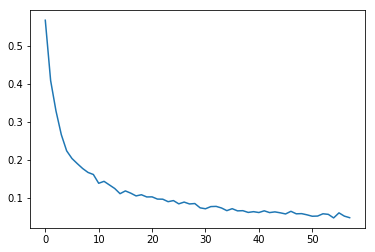

In [19]:
plt.plot(train_losses)
plt.savefig('train_loss.png')

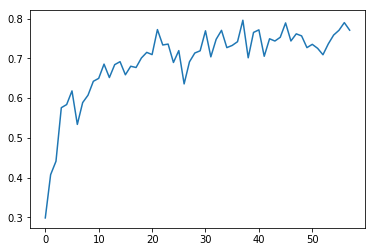

In [20]:
plt.plot(val_accs)
plt.savefig('val_acc.png')